# Analyze the MNIST DATA (5 vs 8)

## Load necessary libraries

In [1]:
from sklearn import svm
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

## Data

### Load data 
- 70K images from 10 classes
- Each image is 28-by-28, stored in a 784 vector
- lable (y) takes 10 different values

In [ ]:
mnist = fetch_openml('mnist_784')

# Extract features (pixel values) and target labels
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

In [ ]:
label_counts = np.bincount(y)
label_counts

In [ ]:
X.shape

Display 12 randomly selected images

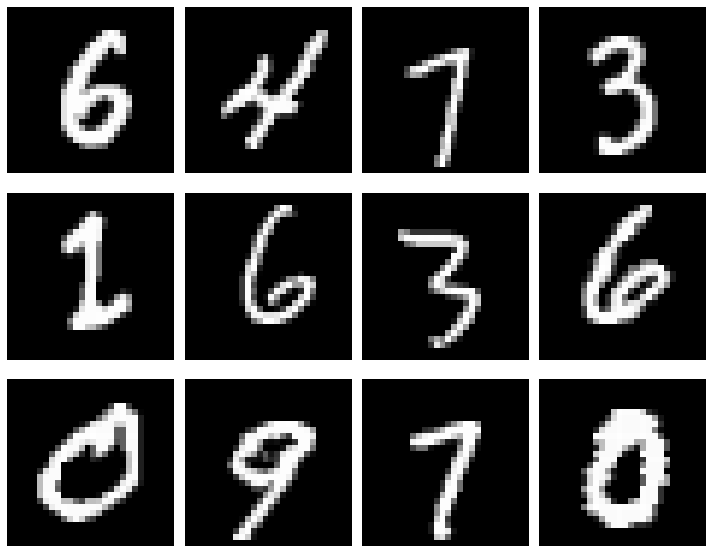

In [6]:
random_indices = np.random.choice(100, size=12, replace=False);

# Display the randomly selected images
fig, axes = plt.subplots(3, 4, figsize=(10, 8))

for i, ax in enumerate(axes.flat):
    image = X[random_indices[i]].reshape(28, 28)  # Reshape the flattened image to 28x28
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Filter data 
Filter the dataset to include only the digits 5 and 8. 

In [7]:
digit_filter = (y == 5) | (y == 8)
X = X[digit_filter]
y = y[digit_filter]

In [8]:
X.shape

(13138, 784)

In [9]:
np.unique(y)

array([5, 8])

In [10]:
n5 = np.count_nonzero(y == 5)
n8 = np.count_nonzero(y == 8)

In [11]:
n5, n8

(6313, 6825)

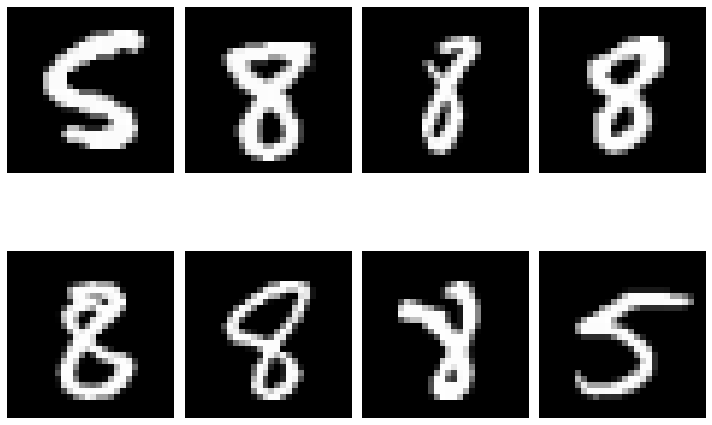

In [12]:
random_indices = np.random.choice(n5+n8, size=8, replace=False);

# Display the randomly selected images
fig, axes = plt.subplots(2, 4, figsize=(10, 8))

for i, ax in enumerate(axes.flat):
    image = X[random_indices[i]].reshape(28, 28)  # Reshape the flattened image to 28x28
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Logistic Regression

60\% training and 40\% test

Try two different Logistic regression models:
- Logistic regression with all 784 features;
- Losgitic regression with 100 top PCs.

In [14]:
from sklearn.linear_model import LogisticRegression

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Create and train the logistic regression model
#model = LogisticRegression()
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# Make predictions on the test set
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Calculate accuracy
accuracy = accuracy_score(y_train, y_train_pred)
print("Test Accuracy:", accuracy)
accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.974498858157828
Test Accuracy: 0.9492009132420092


/Users/feng_macpro/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [17]:
y_test_logits = model.decision_function(X_test)
y_test_prob = model.predict_proba(X_test)
print(y_test_logits[:10])
print(y_test_prob[:10])
print(y_test_pred[:10])

[ -4.83377634   4.5875228   -4.74194553  -5.97698984 -12.85795304
  -0.42786585  12.6782026   -3.9279905    1.76978599  -7.74822774]
[[9.92106387e-01 7.89361343e-03]
 [1.00754914e-02 9.89924509e-01]
 [9.91353748e-01 8.64625173e-03]
 [9.97469967e-01 2.53003263e-03]
 [9.99997395e-01 2.60531845e-06]
 [6.05363937e-01 3.94636063e-01]
 [3.11835257e-06 9.99996882e-01]
 [9.80696763e-01 1.93032371e-02]
 [1.45568945e-01 8.54431055e-01]
 [9.99568680e-01 4.31320486e-04]]
[5 8 5 5 5 5 8 5 8 5]


In [18]:
1/(1+ np.exp(-y_test_logits[0])), 1/(1+ np.exp(y_test_logits[0]))

(0.007893613426839953, 0.9921063865731601)

PCA + Logistic Regression: use top 100 PCs

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Create and train the logistic regression model on the PCA-transformed data
model = LogisticRegression(max_iter=500)
model.fit(X_train_pca, y_train)

# Make predictions on the test set
y_test_pred = model.predict(X_test_pca)
y_train_pred = model.predict(X_train_pca)

# Calculate accuracy
accuracy = accuracy_score(y_train, y_train_pred)
print("Test Accuracy:", accuracy)
accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", accuracy)

# Divide and Conquer

Divide the training data into 11 batches, train a logistic model on each of the batch, and then combine the 11 prediction results. Consider the following two ensemble methods:
- majority voting
- average (or sum) of the logit output and then make decision based on its sign

In [30]:
import warnings

# Define the number of batches
num_batches = 11

# Calculate the batch size
batch_size = len(X_train) // num_batches

# Initialize an empty list to store the models
models = []

# Suppress warnings
warnings.filterwarnings("ignore")

# Split the training data into batches, fit a logistic regression model on each batch
for i in range(num_batches):
    # Calculate the starting and ending indices for the current batch
    start_index = i * batch_size
    end_index = (i + 1) * batch_size
    
    # Create a logistic regression model
    model = LogisticRegression()
    
    # Select the current batch for training
    X_batch = X_train[start_index:end_index]
    y_batch = y_train[start_index:end_index]
    
    # Fit the model on the current batch
    model.fit(X_batch, y_batch)
    
    # Append the trained model to the list
    models.append(model)

# Make predictions on the test set using majority voting
preds_voting = np.zeros(len(y_test))
# Make predictions on the test set using average of logit
preds_logit = np.zeros(len(y_test))

for model in models:
    # Make predictions using each model
    y_pred = model.predict(X_test)
    # Accumulate the predictions using majority voting
    preds_voting += (y_pred == 8)
    
    # Accumulate the predictions using majority voting
    y_pred = model.decision_function(X_test)
    preds_logit += y_pred
    
# Majority voting (selecting the most frequent prediction for each sample)
final_predictions = np.where(preds_voting > len(models) / 2, 8, 5)
accuracy = accuracy_score(y_test, final_predictions)
print("Majority Voting Accuracy:", accuracy)

# Average of logit
final_predictions = np.where(preds_logit > 0, 8, 5)
accuracy = accuracy_score(y_test, final_predictions)
print("Average Logit Accuracy:", accuracy)

Majority Voting Accuracy: 0.9573820395738204
Average Logit Accuracy: 0.9587138508371386


## Iteration Code

We need to repeat the process above 100 times and record the corresponding accuracies. Let's write a function of the process above and then call this function 100 times. 

In [38]:
def iterate_process(X, y):
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
    
    # Define the number of batches
    num_batches = 11
    
    # Randomly shuffle the data indices
    indices = np.random.permutation(len(X))
    
    # Calculate the batch size
    batch_size = len(X_train) // num_batches
    
    # Initialize an empty list to store the models
    models = []
    
    # Split the training data into batches, fit a logistic regression model on each batch
    for i in range(num_batches):
        # Calculate the starting and ending indices for the current batch
        start_index = i * batch_size
        end_index = (i + 1) * batch_size
        
        # Create a logistic regression model
        model = LogisticRegression()
        
        # Select the current batch for training
        X_batch = X_train[start_index:end_index]
        y_batch = y_train[start_index:end_index]
        
        # Fit the model on the current batch
        model.fit(X_batch, y_batch)
        
        # Append the trained model to the list
        models.append(model)
    
    # Make predictions on the test set using majority voting
    preds_voting = np.zeros(len(y_test))
    # Make predictions on the test set using average of logit
    preds_logit = np.zeros(len(y_test))

    for model in models:
        # Make predictions using each model
        y_pred = model.predict(X_test)
        # Accumulate the predictions using majority voting
        preds_voting += (y_pred == 8)
    
        # Accumulate the predictions using majority voting
        y_pred = model.decision_function(X_test)
        preds_logit += y_pred
    
    accuracy = np.zeros(2)
    
    # Majority voting (selecting the most frequent prediction for each sample)
    final_predictions = np.where(preds_voting > len(models) / 2, 8, 5)
    accuracy[0] = accuracy_score(y_test, final_predictions)
    # Average of logit
    final_predictions = np.where(preds_logit > 0, 8, 5)
    accuracy[1] = accuracy_score(y_test, final_predictions)
    
    return accuracy

In [39]:
# Number of times to repeat the process
num_repeats = 3

# Initialize an empty vector to store accuracies
accuracies = np.zeros((num_repeats, 2))

# Repeat the process and store accuracies
for i in range(num_repeats):
    accuracies[i] = iterate_process(X, y)

# Print the accuracies
print("Accuracies:", accuracies)

Accuracies: [[0.95300609 0.95414764]
 [0.94977169 0.95224505]
 [0.95319635 0.95281583]]


In [40]:
len(X)

13138

In [41]:
len(y)

13138

In [42]:
X.shape

(13138, 784)